## Primeras pruebas en la exploración del catálogo GAIA DR3


#### Requirements

In [72]:
%load_ext autoreload
%autoreload 2
    
import sys
import os

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
    
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astroquery.heasarc import Heasarc
from astroquery.esa.xmm_newton import XMMNewton

from src.gaia_dr3.etls.download_data import get_object, get_object_from_simbad, get_cluster, get_skycoords
from src.gaia_dr3.etls.stadistics import get_uwe_from_gaia, get_u0_g_c, get_ruwe_from_gaia
from src.gaia_dr3.etls.utils import convert_mas_yr_in_km_s

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from astroquery.heasarc import Heasarc
from astropy.coordinates import SkyCoord
pos = SkyCoord.from_name('ngc 104')
tab = Heasarc.query_region(pos, mission='chanmaster', radius=2*u.deg
                          )
tab

OBSID,STATUS,NAME,RA,DEC,TIME,DETECTOR,GRATING,EXPOSURE,TYPE,PI,PUBLIC_DATE,SEARCH_OFFSET_
,,,deg,deg,mjd,,,s,,,mjd,
int32,bytes20,bytes50,float64,float64,bytes16,bytes6,bytes4,float64,bytes3,bytes40,int32,bytes38
6233,archived,47 Tuc,6.02167,-72.08053,53737.2343865741,HRC-S,NONE,97930,GO,Rutledge,53740,"0.056 (6.0223177399,-72.0814424661)\n"
2738,archived,47 TUCANAE,6.02417,-72.08089,52558.070775463,ACIS-S,NONE,69860,GO,Grindlay,52941,"0.048 (6.0223177399,-72.0814424661)\n"
2737,archived,47 TUCANAE,6.02417,-72.08089,52549.7848032407,ACIS-S,NONE,66110,GO,Grindlay,52921,"0.048 (6.0223177399,-72.0814424661)\n"
2736,archived,47 TUCANAE,6.02417,-72.08089,52547.5586574074,ACIS-S,NONE,66110,GO,Grindlay,52916,"0.048 (6.0223177399,-72.0814424661)\n"
2735,archived,47 TUCANAE,6.02417,-72.08089,52546.7068981481,ACIS-S,NONE,66100,GO,Grindlay,52916,"0.048 (6.0223177399,-72.0814424661)\n"
15747,archived,47 Tuc,6.01456,-72.08109,56909.8145486111,ACIS-S,NONE,55170,GO,Bogdanov,57421,"0.145 (6.0223177399,-72.0814424661)\n"
6236,archived,47 Tuc,6.02167,-72.08053,53740.4785532407,HRC-S,NONE,51920,GO,Rutledge,53743,"0.056 (6.0223177399,-72.0814424661)\n"
5545,archived,47 Tuc,6.02167,-72.08053,53727.2096527778,HRC-S,NONE,51870,GO,Rutledge,53731,"0.056 (6.0223177399,-72.0814424661)\n"


In [70]:
from astroquery.esa.xmm_newton import XMMNewton

# Coordenadas aproximadas de NGC 104 (47 Tucanae)
ra = 6.0223  # Ascensión recta (RA) en grados
dec = -72.0814  # Declinación (Dec) en grados
radius = 0.1  # Radio de búsqueda en grados

# # Ejecutar la consulta TAP
query_results = XMMNewton.query_xsa_tap(f"""
SELECT * FROM xsa.v_publication_observation
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra}, {dec}, {radius})
)
""")

# # Mostrar los resultados
print(query_results)  


HTTPError: Error 400: 
Cannot parse query '
SELECT  TOP 2000 * FROM xsa.v_publication_observation
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', 6.0223, -72.0814, 0.1)
)
' for job '1737836074936O': 2 unresolved identifiers: ra [l.4 c.19 - l.4 c.21], dec [l.4 c.23 - l.4 c.26] !
 - Unknown column "ra" !
 - Unknown column "dec" !


In [2]:
Gaia.ROW_LIMIT = -1
results = get_cluster("ngc104", rc_scale=1.0)
results6 = get_cluster("ngc104", rc_scale=6.0)

df_rc1 = results.to_pandas()
df_rc6 = results6.to_pandas()

print(f"Rc1: {df_rc1.shape[0]} elementos")
print(f"Rc6: {df_rc6.shape[0]} elementos")

df_rc1["RUWE_np5"] = get_ruwe_from_gaia(df_rc1, 5)
df_rc1["RUWE_np6"] = get_ruwe_from_gaia(df_rc1, 6)

df_rc6["RUWE_np5"] = get_ruwe_from_gaia(df_rc6, 5)
df_rc6["RUWE_np6"] = get_ruwe_from_gaia(df_rc6, 6)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Rc1: 85 elementos
Rc6: 5776 elementos


Para dibujar el diagrama usar todo el catálogo.
Usar filtro de RUWE < 1.4

El valor de 50 km/s que aparece en primer documento.

In [3]:
df_rc1["pm_kms"] = convert_mas_yr_in_km_s(df_rc1["parallax"].values, df_rc1["pm"].values)
df_rc1["pmra_kms"] = convert_mas_yr_in_km_s(df_rc1["parallax"].values, df_rc1["pmra"].values)
df_rc1["pmdec_kms"] = convert_mas_yr_in_km_s(df_rc1["parallax"].values, df_rc1["pmdec"].values)

df_rc6["pm_kms"] = convert_mas_yr_in_km_s(df_rc6["parallax"].values, df_rc6["pm"].values)
df_rc6["pmra_kms"] = convert_mas_yr_in_km_s(df_rc6["parallax"].values, df_rc6["pmra"].values)
df_rc6["pmdec_kms"] = convert_mas_yr_in_km_s(df_rc6["parallax"].values, df_rc6["pmdec"].values)

In [4]:
mask_rc6 = (df_rc6.pmra_kms.abs() > 50) & (df_rc6.pmdec_kms.abs() > 50) & (df_rc6.parallax > 0) & (df_rc6.parallax_error < 0.3)
df_rc6.loc[mask_rc6, ["pm_kms", "pmra_kms", "pmdec_kms"]].describe(percentiles=[0.05,0.25,0.50,0.75,0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
pm_kms,543.0,477.920302,1417.037533,75.677359,100.882966,134.578617,171.019400,318.824565,1580.687970,21424.378425
pmra_kms,543.0,427.198888,1297.448349,56.722071,81.261854,115.094019,153.152140,274.128344,1361.276415,19054.882650
pmdec_kms,543.0,-201.301108,574.473469,-9793.641611,-656.137465,-134.971882,-79.556713,-60.661167,-51.797139,90.725645


In [47]:
df_rc6.columns.values

array(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pm', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'astrometric_params_solved', 'astrometric_primary_flag',
       'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error',
       'ra_pseudocolour_corr', 'dec_pseudocolour_corr',
       'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr',
       'pmdec_pseudocolour_corr', 'astrometric_matche

Text(0, 0.5, 'B')

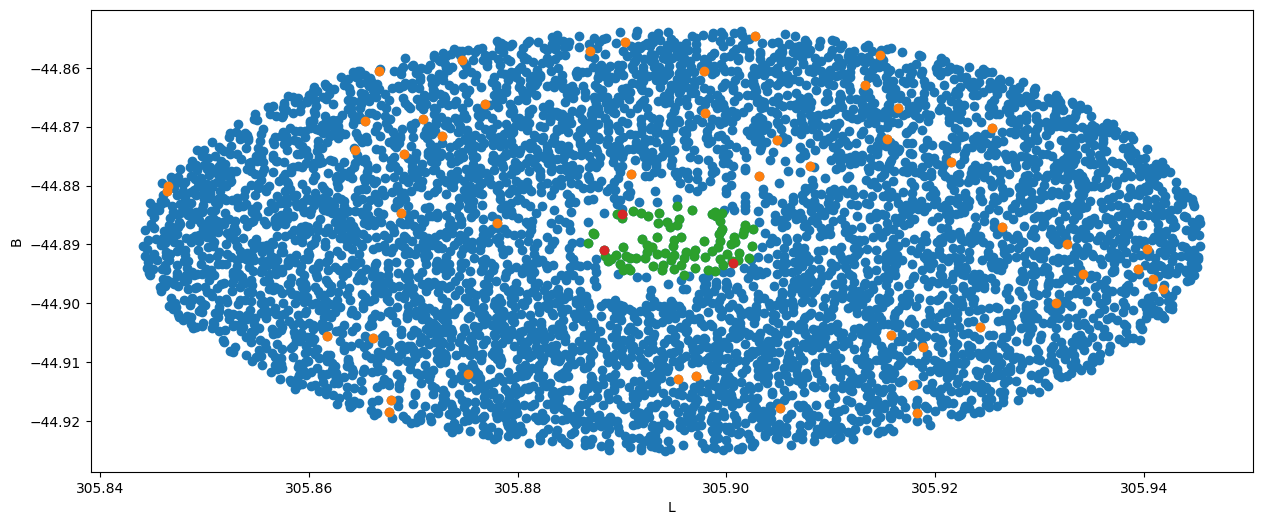

In [50]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 6))

plt.scatter(df_rc6.l.values, df_rc6.b.values)
df_sample = df_rc6[mask_rc6 & (df_rc6.RUWE_np5 < 1.4)]
plt.scatter(df_sample[df_sample.pm_kms >= 150].l.values, df_sample[df_sample.pm_kms >= 150].b.values)
plt.scatter(df_rc1.l.values, df_rc1.b.values)
plt.scatter(df_rc1[df_rc1.pm_kms >= 150].l.values, df_rc1[df_rc1.pm_kms >= 150].b.values)

# Etiquetas de los ejes
ax.set_xlabel('L')
ax.set_ylabel('B')

# Ajustar límites de los ejes si es necesario
# ax.set_xlim(305.8, 306)
# ax.set_ylim(-45, -44.5)

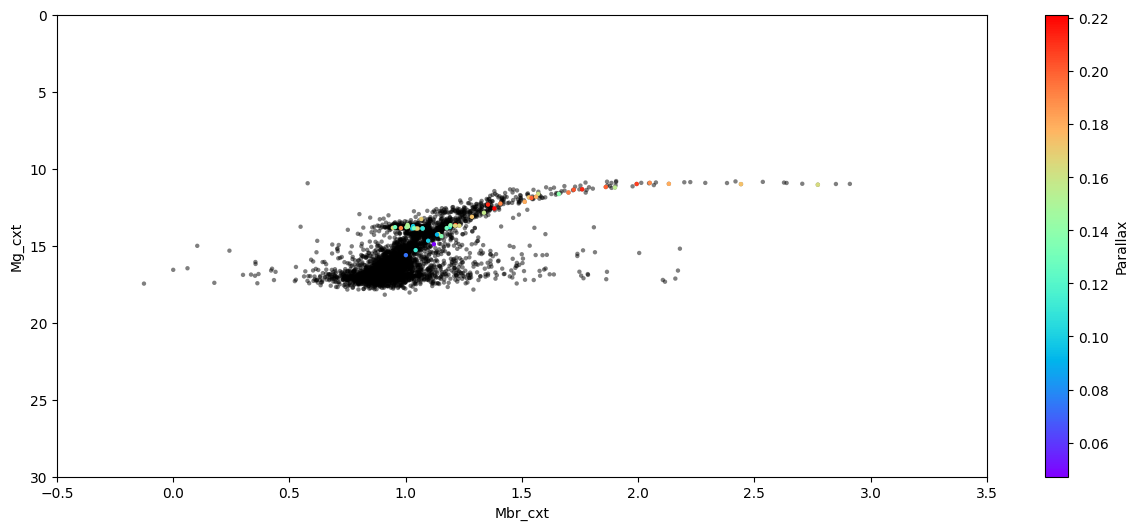

In [35]:
dic_colors = mcolor.TABLEAU_COLORS

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 6))

# Crear el scatter plot
plt.scatter(x=df_rc6.bp_rp, y=df_rc6.phot_g_mean_mag,s=10, c="k", edgecolor='none', alpha=0.5)
scatter = plt.scatter(
    x=df_sample[df_sample.pm_kms>=150].bp_rp, 
    y=df_sample[df_sample.pm_kms>=150].phot_g_mean_mag, 
    c=df_sample[df_sample.pm_kms>=150].parallax, 
    cmap='rainbow', s=10, edgecolor='none')

# Añadir barra de colores
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Parallax')

# Etiquetas de los ejes
ax.set_xlabel('Mbr_cxt')
ax.set_ylabel('Mg_cxt')

# Ajustar límites de los ejes si es necesario
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(0, 30)
plt.gca().invert_yaxis()
# Mostrar la gráfica
plt.show()

## $\omega$ Centauri - (Häberle et al., 2024)

In [19]:
Gaia.ROW_LIMIT = -1
results = get_cluster("ngc5139", rc_scale=1.0)
results6 = get_cluster("ngc5139", rc_scale=6.0)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [20]:
df_rc1 = results.to_pandas()
df_rc6 = results6.to_pandas()

print(f"Rc1: {df_rc1.shape[0]} elementos")
print(f"Rc6: {df_rc6.shape[0]} elementos")

df_rc1["RUWE_np5"] = get_ruwe_from_gaia(df_rc1, 5)
df_rc1["RUWE_np6"] = get_ruwe_from_gaia(df_rc1, 6)

df_rc6["RUWE_np5"] = get_ruwe_from_gaia(df_rc6, 5)
df_rc6["RUWE_np6"] = get_ruwe_from_gaia(df_rc6, 6)

Rc1: 4694 elementos
Rc6: 169556 elementos


In [23]:
df_rc1.loc[:, ["pm", "pmra", "pmdec"]].describe(percentiles=[0.05,0.25,0.50,0.75,0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
pm,1305.0,7.525694,1.382341,1.709723,5.422870,6.796181,7.520118,8.217635,9.592497,21.488899
pmra,1305.0,-3.318007,1.109009,-10.629693,-4.997901,-3.924953,-3.276828,-2.663604,-1.648850,0.585249
pmdec,1305.0,-6.644207,1.470889,-20.593219,-8.648990,-7.364539,-6.682559,-5.965033,-4.484920,1.876475


In [26]:
columns = ["solution_id", "DESIGNATION", "SOURCE_ID", "ra", "dec", "parallax", 'pm', 'phot_g_mean_mag', "bp_rp", "RUWE_np5"]

mask_error = (df_rc1.pmra_error < 0.08) & (df_rc1.pmdec_error < 0.08) & (df_rc1.parallax_error < 0.08)

df_stars = df_rc1.loc[(~df_rc1["RUWE_np5"].isna()) & mask_error, columns].sort_values("pm", ascending=False)
df_stars[df_stars.pm >= 4.41]

,solution_id,DESIGNATION,SOURCE_ID,ra,dec,parallax,pm,phot_g_mean_mag,bp_rp,RUWE_np5
3868,1636148068921376768,Gaia DR3 6083701705983015552,6083701705983015552,201.645480,-47.471060,0.112714,9.569691,12.346845,1.523997,2.186182
2182,1636148068921376768,Gaia DR3 6083698854124839040,6083698854124839040,201.734598,-47.487699,0.195634,9.202696,11.529737,1.589243,1.142572
4455,1636148068921376768,Gaia DR3 6083701912141565184,6083701912141565184,201.744183,-47.458259,0.236299,9.075792,12.154989,1.503436,1.178013
1928,1636148068921376768,Gaia DR3 6083698755345479040,6083698755345479040,201.723194,-47.497283,0.162147,9.073417,11.830122,1.546110,1.150281
3532,1636148068921376768,Gaia DR3 6083702122622928384,6083702122622928384,201.691024,-47.445567,0.207204,8.819277,11.378763,1.660378,1.192588
...,...,...,...,...,...,...,...,...,...,...
547,1636148068921376768,Gaia DR3 6083701744642624768,6083701744642624768,201.684531,-47.490085,0.043815,5.995595,13.038641,1.334392,1.010006
1132,1636148068921376768,Gaia DR3 6083698819765087360,6083698819765087360,201.723363,-47.486186,0.171511,5.910168,11.710671,1.545373,1.158437
1009,1636148068921376768,Gaia DR3 6083702015220693504,6083702015220693504,201.671219,-47.474534,0.232812,5.909645,12.796445,1.350639,0.878023
2905,1636148068921376768,Gaia DR3 6083701637263545472,6083701637263545472,201.650933,-47.478784,0.063748,5.874531,13.124449,1.296809,1.298483


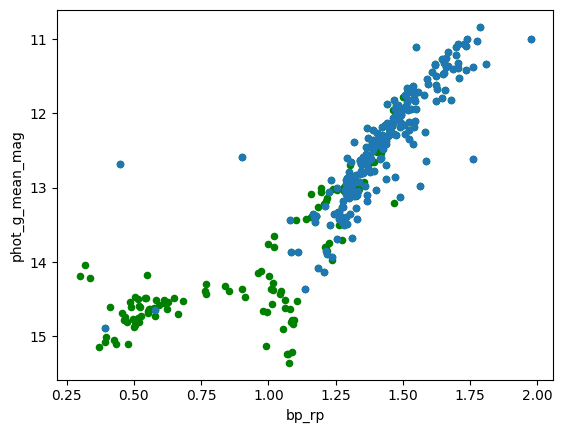

In [38]:
ax = df_rc1[~df_rc1["RUWE_np5"].isna()].plot.scatter(x="bp_rp", y="phot_g_mean_mag", color="green")
df_stars[df_stars.pm >= 4.41].plot.scatter(ax=ax,x="bp_rp", y="phot_g_mean_mag")
plt.gca().invert_yaxis()

In [14]:
df_rc1.pm

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
4689    8.386451
4690    7.326908
4691         NaN
4692    7.665855
4693         NaN
Name: pm, Length: 4694, dtype: float32

In [41]:
results.columns

<TableColumns names=('solution_id','DESIGNATION','SOURCE_ID','random_index','ref_epoch','ra','ra_error','dec','dec_error','parallax','parallax_error','parallax_over_error','pm','pmra','pmra_error','pmdec','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr','astrometric_n_obs_al','astrometric_n_obs_ac','astrometric_n_good_obs_al','astrometric_n_bad_obs_al','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','astrometric_params_solved','astrometric_primary_flag','nu_eff_used_in_astrometry','pseudocolour','pseudocolour_error','ra_pseudocolour_corr','dec_pseudocolour_corr','parallax_pseudocolour_corr','pmra_pseudocolour_corr','pmdec_pseudocolour_corr','astrometric_matched_transits','visibility_periods_used','astrometric_sigma5d_max','matched_transits','new_matched_transits','matched_transits_removed','ip